## Viz -1

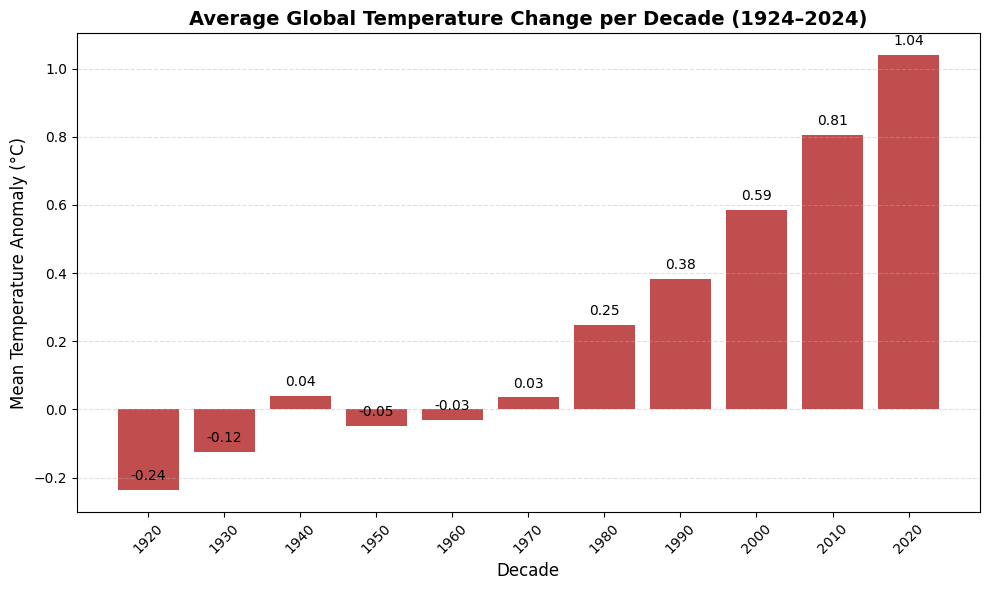

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the NASA GISTEMP dataset (global land + ocean)
df = pd.read_csv("../data/NASA_Data.csv", skiprows=1)
df.columns = df.columns.str.strip()
# Keep relevant columns
df = df[['Year', 'J-D']].dropna()
df = df[(df['Year'] >= 1924) & (df['Year'] <= 2024)]
df['J-D'] = pd.to_numeric(df['J-D'], errors='coerce')


# Compute average temperature anomaly per decade 
df['Decade'] = (df['Year'] // 10) * 10  # e.g., 1924 → 1920s
decade_means = df.groupby('Decade')['J-D'].mean().reset_index()


# Plot 
plt.figure(figsize=(10,6))
bars = plt.bar(decade_means['Decade'].astype(str), decade_means['J-D'], color='firebrick', alpha=0.8)


# Add labels and styling
plt.title("Average Global Temperature Change per Decade (1924–2024)", fontsize=14, weight='bold')
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Mean Temperature Anomaly (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)


# Annotate bars with values 
for bar in bars:
   height = bar.get_height()
   plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}",
            ha='center', va='bottom', fontsize=10)
   

plt.tight_layout()
plt.savefig("../plots/viz1.png", dpi=300, bbox_inches='tight')
plt.show()


## Viz2

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load data
df = pd.read_csv("../data/NASA_Data.csv", skiprows=1)
df = df[["Year", "J-D"]].dropna()
df["J-D"] = pd.to_numeric(df["J-D"], errors="coerce")
df = df[(df["Year"] >= 1924) & (df["Year"] <= 2024)]

years = df["Year"].values
Z_line = df["J-D"].values

depth_layers = 50  # increase for thicker 3D surface
Z = np.tile(Z_line, (depth_layers, 1))

X, Y = np.meshgrid(years, np.arange(depth_layers))

fig = go.Figure(data=[
    go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale="RdBu_r",
        showscale=True,
        opacity=0.95
    )
])

fig.update_layout(
    title="3D Global Temperature Anomalies (1924–2024)",
    width=1100,
    height=600,
    scene=dict(
        xaxis_title="Year",
        yaxis_title="Depth Layer",
        zaxis_title="Temperature Anomaly (°C)",
        camera=dict(eye=dict(x=1.8, y=1.8, z=0.8))  # better 3D angle
    )
)
fig.show()
fig.write_html("../plots/viz2.html")



## viz-3

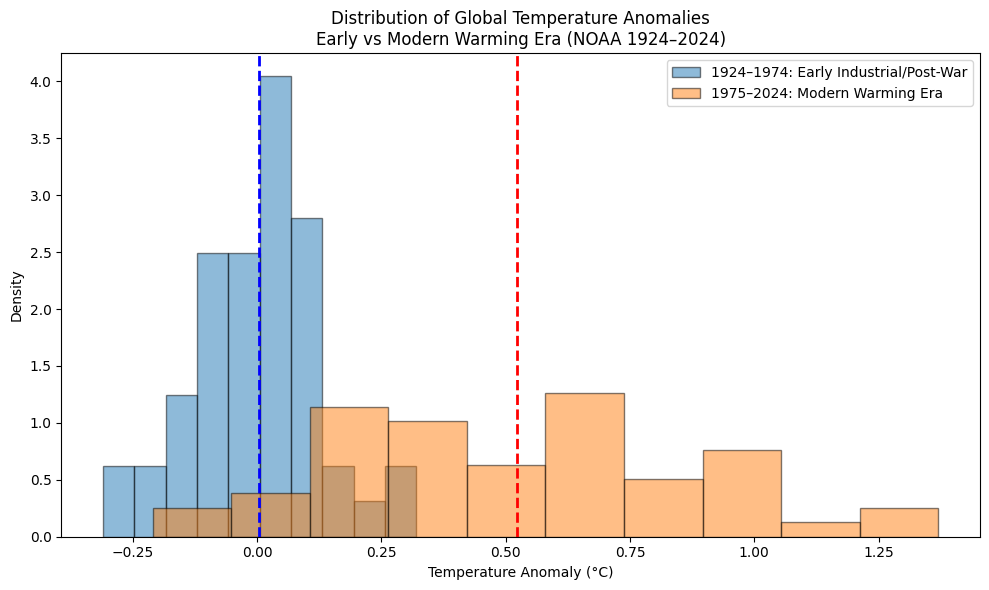

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

noaa = pd.read_csv("../data/NOAA_GlobalData.csv", comment='#')
noaa = noaa[(noaa["Year"] >= 1924) & (noaa["Year"] <= 2024)]

early = noaa[(noaa["Year"] >= 1924) & (noaa["Year"] <= 1974)]
late = noaa[(noaa["Year"] >= 1975) & (noaa["Year"] <= 2024)]

plt.figure(figsize=(10, 6))

plt.hist(early["Anomaly"], bins=10, alpha=0.5, edgecolor="black", density=True, label="1924–1974: Early Industrial/Post-War")
plt.hist(late["Anomaly"], bins=10, alpha=0.5, edgecolor="black", density=True, label="1975–2024: Modern Warming Era")

plt.axvline(early["Anomaly"].mean(), color="blue", linestyle="--", linewidth=2)
plt.axvline(late["Anomaly"].mean(), color="red", linestyle="--", linewidth=2)

plt.title("Distribution of Global Temperature Anomalies\nEarly vs Modern Warming Era (NOAA 1924–2024)")
plt.xlabel("Temperature Anomaly (°C)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/viz3.png", dpi=300, bbox_inches='tight')
plt.show()

## Viz-4
 

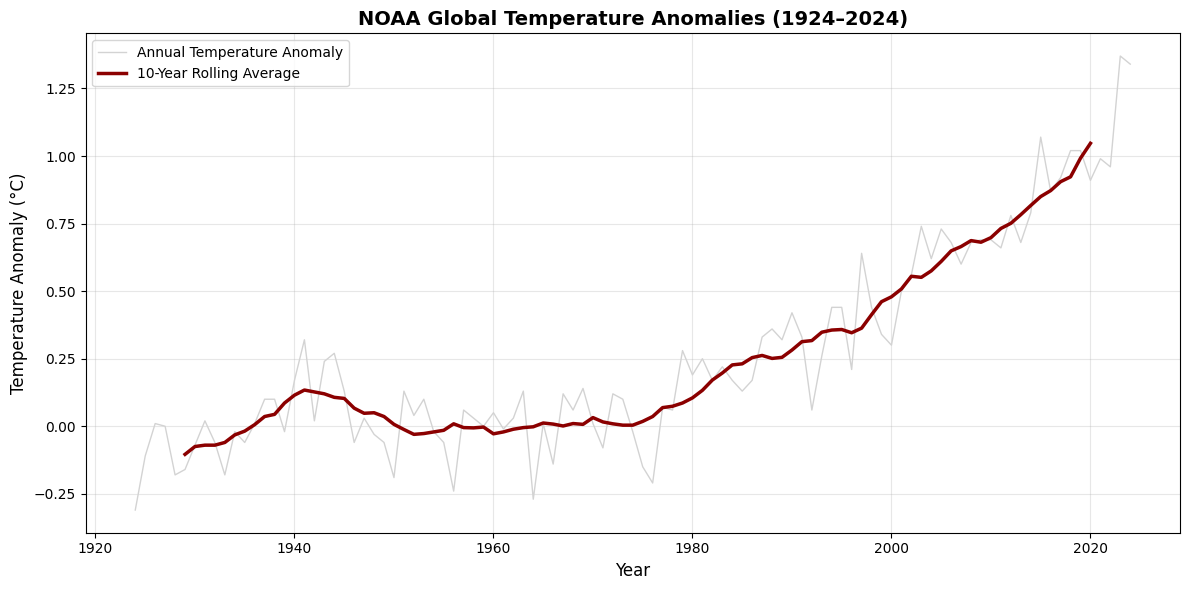

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

noaa = pd.read_csv("../data/NOAA_GlobalData.csv", comment='#')

# Keep only 1924–2024
noaa = noaa[(noaa['Year'] >= 1924) & (noaa['Year'] <= 2024)]

# print(noaa.head())
# print(noaa.tail())

noaa = noaa.sort_values('Year')

noaa['Rolling_10yr'] = noaa['Anomaly'].rolling(window=10, center=True).mean()

# print(noaa.head(15))
# print(noaa.tail(15))
plt.figure(figsize=(12, 6))

# Actual annual anomaly
plt.plot(noaa['Year'], noaa['Anomaly'],
         color='lightgray', linewidth=1, label='Annual Temperature Anomaly')

# Smoothed trend line
plt.plot(noaa['Year'], noaa['Rolling_10yr'],
         color='darkred', linewidth=2.5, label='10-Year Rolling Average')

# Styling
plt.title("NOAA Global Temperature Anomalies (1924–2024)", fontsize=14, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature Anomaly (°C)", fontsize=12)
plt.grid(alpha=0.3)

plt.legend()
plt.tight_layout()
plt.savefig("../plots/viz4.png", dpi=300, bbox_inches='tight')

plt.show()